## Task 1

In [ ]:
!pip install ucimlrepo
!pip install scikit-learn
!pip install dtreeviz

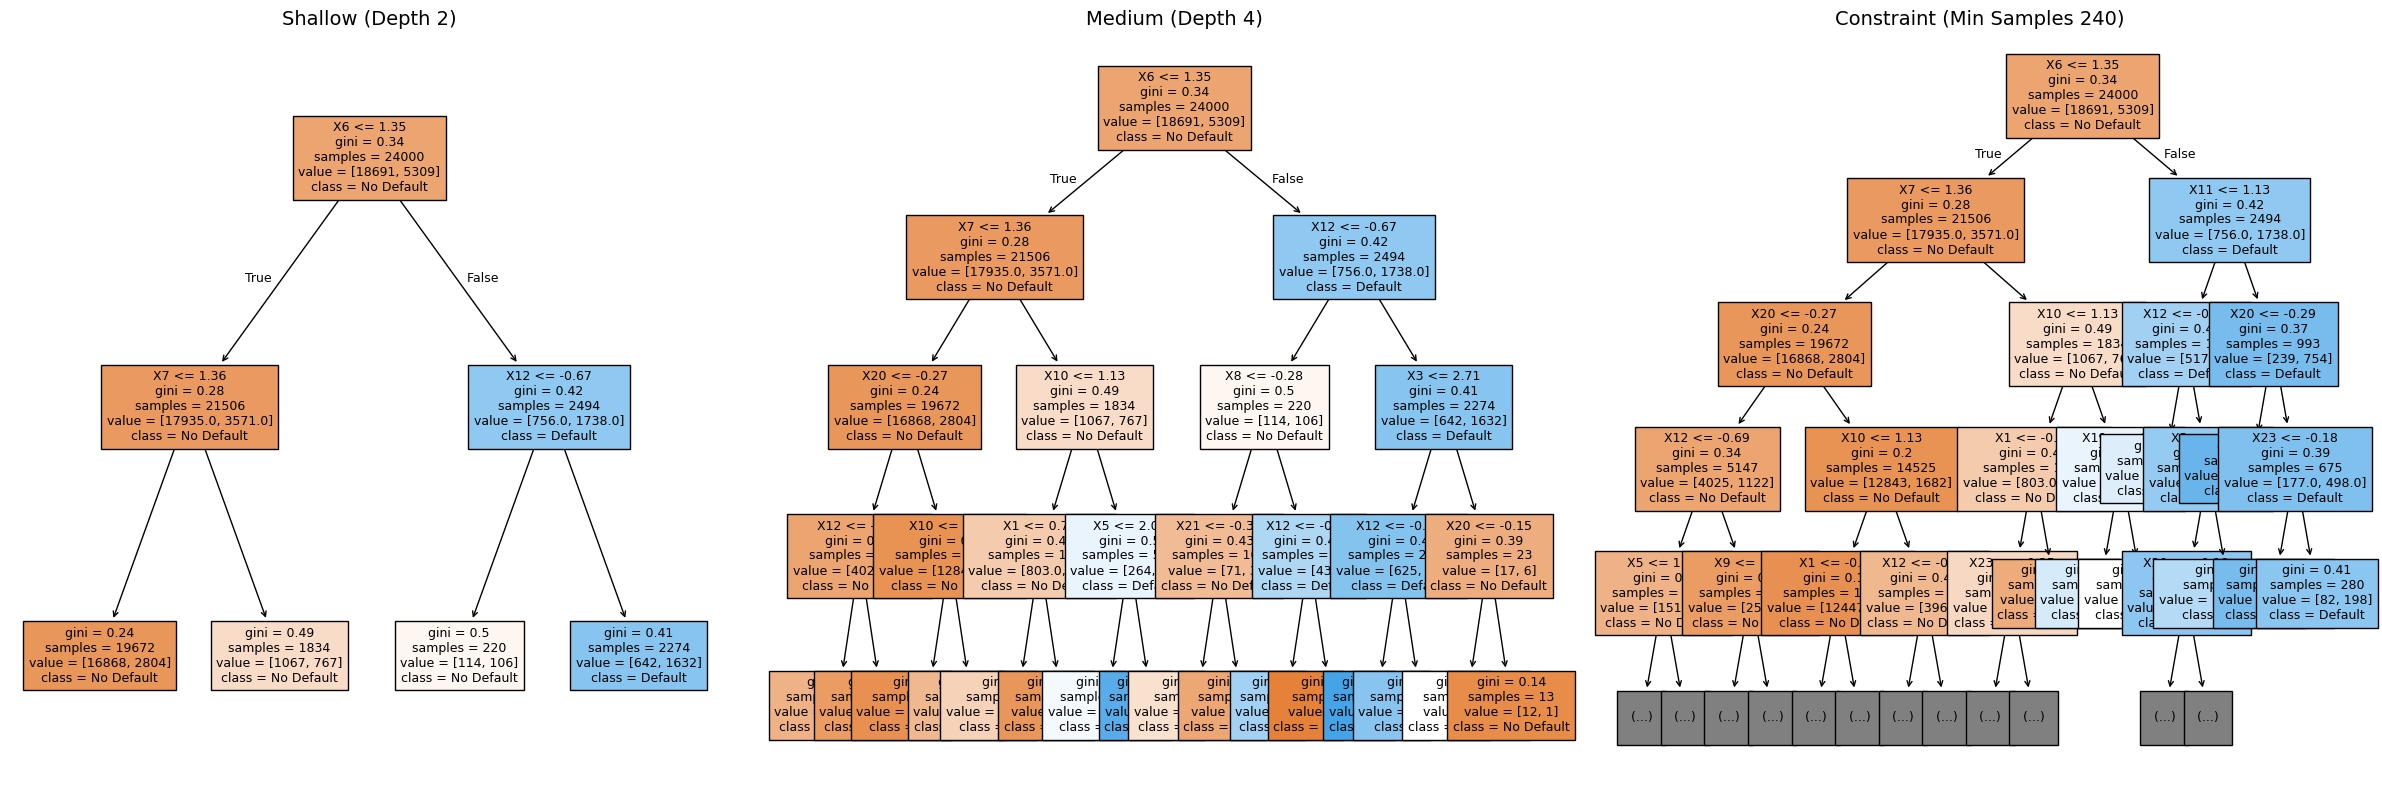

                        Setting Test Error Train Error  Total Leaves  \
0             Shallow (Depth 2)     18.32%      18.00%             4   
1              Medium (Depth 4)     18.17%      17.67%            16   
2  Constraint (Min Samples 240)     18.15%      17.89%            66   

   Avg Samples/Leaf  
0           6000.00  
1           1500.00  
2            363.64  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import pandas as pd

default_of_credit_card_clients = fetch_ucirepo(id=350)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

X_final = X.drop(columns=['X13', 'X14', 'X15', 'X16', 'X17'])

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

configs = [
    {'name': 'Shallow (Depth 2)', 'params': {'max_depth': 2}},
    {'name': 'Medium (Depth 4)', 'params': {'max_depth': 4}},
    {'name': 'Constraint (Min Samples 240)', 'params': {'min_samples_leaf': 240}}
]

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
results_summary = []
for ax, config in zip(axes, configs):
    dt = DecisionTreeClassifier(**config['params'], random_state=42)
    dt.fit(X_train, y_train)

    plot_tree(dt,
              feature_names=list(X_final.columns),
              max_depth=4,
              filled=True,
              ax=ax,
              fontsize=9,
              class_names=["No Default", "Default"],
              precision=2)

    ax.set_title(config['name'], fontsize=14)
    y_pred = dt.predict(X_test_scaled)
    y_train_pred = dt.predict(X_train)
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test_flat, y_pred)

    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    node_samples = dt.tree_.n_node_samples
    is_leaves = (children_left == -1) & (children_right == -1)

    avg_samples = node_samples[is_leaves].mean()
    num_leaves = is_leaves.sum()

    results_summary.append({
        'Setting': config['name'],
        'Test Error': f"{test_error:.2%}",
        'Train Error': f"{train_error:.2%}",
        'Total Leaves': num_leaves,
        'Avg Samples/Leaf': round(avg_samples, 2)
    })

plt.tight_layout()
plt.show()

for config in configs:
    dt = DecisionTreeClassifier(**config['params'], random_state=42)
    dt.fit(X_train, y_train)



print(pd.DataFrame(results_summary))

## Analysis on depth and complexity

The further we change the depth the more branches we create which is equivalent to $2^d$ where d=depth. As well, as we increase the depth, we see there is more complexity in the average samples per leaf as there are less points in each leaf as we increase depth. When don't limit the depth, but instead limit the nodes of the tree by the amount of minimum samples (in this ex. we chose 1% of the total samples (24000*.01 = 240). With a minimum samples solution, we see there is a small improvement in test error compared to depth configurations, but we do have more total leaves which results in more complexity. All three configurations were in the correct test and training error as per the research paper below.



Configuration help:
https://medium.com/@chaitanyayadav1412/demystifying-decision-tree-hyperparameters-in-scikit-learn-f4a5350d2786.

Paper used to compare errors:
https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33

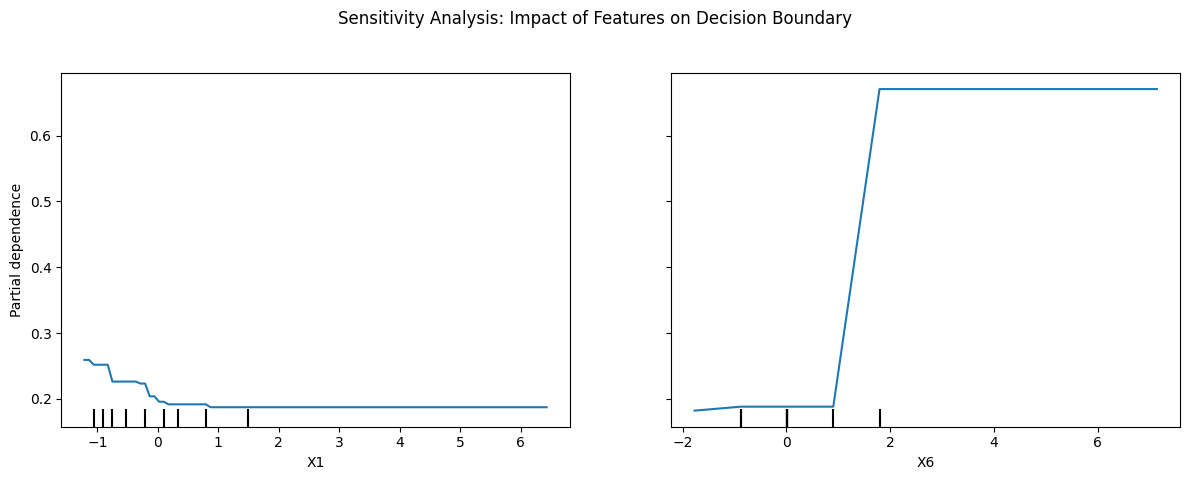

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

dt_final = DecisionTreeClassifier(min_samples_leaf=240, random_state=42)
dt_final.fit(X_train, y_train)


features_to_plot = [0, 5]

fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(dt_final, X_train, features_to_plot,
                                        feature_names=X_final.columns, ax=ax)

plt.suptitle("Sensitivity Analysis: Impact of Features on Decision Boundary")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Sensitivity Analysis

Sensitivity analysis is a technique used to determine how much the variation in a model's output can be correlated to variations in specific input features. In simple terms it shows how sensitive the model is to changes in a variable.

Comparing X1 and X6 via sensitivity analysis, we see that X1 (amount of credit given) doesn't have any sensitivity related to defaulting, but we see that X6 (History of past payment for september) does have a high sensitivity related to defaulting. This is correlation makes sens as the more X6 increases, the more the person has been late on their payment. If this is the case for X6, it is most likely true for other months as well therefore there is a strong correlation between X6 and defaulting.

Paper used for sensitivity analysis:
https://arxiv.org/html/2312.13234v2

## Task 2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, n_jobs=-1, random_state=42, tree_method='hist')
}


fold_counts = [5, 10, 15]
metrics = ['accuracy', 'precision', 'f1']
ensemble_results = []

for name, model in models.items():
    print(f"Starting {name}...")
    for k in fold_counts:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

        scores = cross_validate(model, X_train, y_train, cv=skf, scoring=metrics, n_jobs=-1)

        ensemble_results.append({
            'Algorithm': name,
            'Folds': k,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'F1-Score': scores['test_f1'].mean()
        })
    print(f"Finished {name}.")

import pandas as pd
df_results = pd.DataFrame(ensemble_results)
print(df_results)

Starting Random Forest...
Finished Random Forest.
Starting XGBoost...
Finished XGBoost.
       Algorithm  Folds  Accuracy  Precision  F1-Score
0  Random Forest      5  0.815000   0.642859  0.468229
1  Random Forest     10  0.816542   0.649391  0.471975
2  Random Forest     15  0.816417   0.649449  0.471350
3        XGBoost      5  0.818500   0.660630  0.473864
4        XGBoost     10  0.819292   0.664183  0.476012
5        XGBoost     15  0.819000   0.661930  0.476597


## Analysis of K-Fold Cross-Validation

Since out accuracy, precision, and f1-score were barely changed in differnt values of k, therefore we can say our model is robust and not sensitive to specific subsets of data therefore the performance ranking does not changed on the metric used. This proves that the decision boundaries for thresholds such as X6 are stable and represent globalized patterns rather than noise.

## Analysis of Random Forest v XGBoost

Comparing both models, we see that XGBoost outperforms RandomForest in all three categories for all 3 different folds. This is due to XGBoost reducing bias.

## Source for Stratified K Fold
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

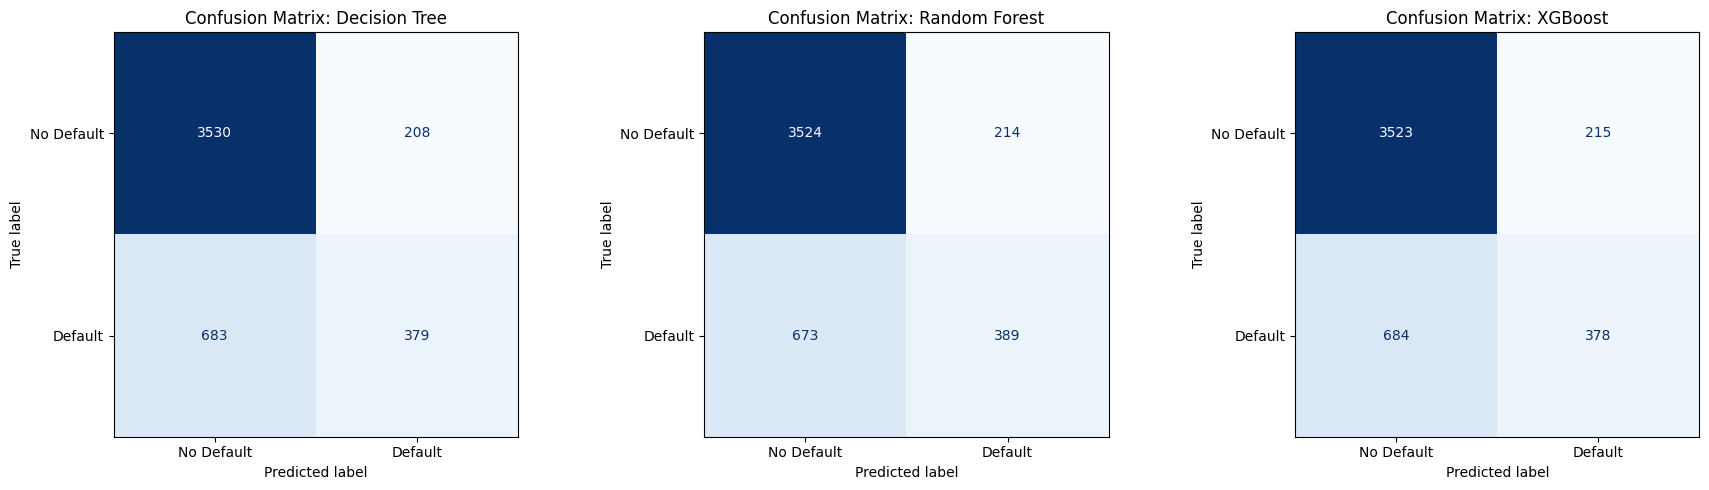

--- Full Statistical Comparison (15-Fold Accuracy) ---
Decision Tree Mean: 0.8202
Random Forest Mean: 0.8164
XGBoost Mean:       0.8190
---------------------------------------------
P-Value (DT vs XGBoost): 0.402463
P-Value (RF vs XGBoost): 0.081434
Conclusion: The difference is not statistically significant.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_rel
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

dt_model = DecisionTreeClassifier(min_samples_leaf=240, random_state=42)
rf_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
xgb_model = XGBClassifier(n_estimators=50, n_jobs=-1, tree_method='hist', random_state=42)

X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

models = [dt_model, rf_model, xgb_model]
names = ['Decision Tree', 'Random Forest', 'XGBoost']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model, name) in enumerate(zip(models, names)):
    model.fit(X_train_part, y_train_part)
    y_pred = model.predict(X_val_part)
    cm = confusion_matrix(y_val_part, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"Confusion Matrix: {name}")

plt.tight_layout()
plt.show()

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

dt_scores = cross_val_score(dt_model, X_train, y_train, cv=skf)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=skf)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=skf)

t_stat_dt_xgb, p_val_dt_xgb = ttest_rel(dt_scores, xgb_scores)
t_stat_rf_xgb, p_val_rf_xgb = ttest_rel(rf_scores, xgb_scores)

print(f"--- Full Statistical Comparison (15-Fold Accuracy) ---")
print(f"Decision Tree Mean: {dt_scores.mean():.4f}")
print(f"Random Forest Mean: {rf_scores.mean():.4f}")
print(f"XGBoost Mean:       {xgb_scores.mean():.4f}")
print("-" * 45)
print(f"P-Value (DT vs XGBoost): {p_val_dt_xgb:.6f}")
print(f"P-Value (RF vs XGBoost): {p_val_rf_xgb:.6f}")
if p_value < 0.05:
    print("Conclusion: The difference in performance is statistically significant (Reject Null Hypothesis).")
else:
    print("Conclusion: The difference is not statistically significant.")

## Trade offs between Bias and Variance

Across the average accuracies for a 15 fold, we see there is not significant difference between decision tree, random forest, and XGBoost. We can tell that there is a small difference in Random Forest due to Random Forest creating an increase in Bias while XGBoost and Decision Tree are relatively similar here. This shows that Boosting and Bagging don't provide any significant data. This is can be explained via our sensitivity analysis that shows X6 being a very sensitive feature in our data set. Because there is extreme sensitivity, a normal Decision Tree would be able to split this efficiently by the most sensitive values due to their entropy values. XGBoost is used to find small errors in data sets with smaller sensitivities which explains why it wasn't as performant in this dataset. We can also use a similiar explanation to see why Random Forest didn't improve as most trees will want to split on the sensitive features first which means there is very little variance between the first few splits in the different trees. Since credit risk can have factors that can't be measured (losing a job, medical emergencies, etc) the other 18% of data is extremely hard to predict since it is not logged which is therefore hidden as noise and cannot be predicted as a pattern.

We can also refer to our p-values that show there is no significant statistical difference between XGBoost and Decision Trees or Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, tree_method='hist', n_jobs=-1, random_state=42)

param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.5, 0.7, 0.9, 1.0]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='accuracy',
                                   n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

Best Parameters: {'subsample': 0.5, 'max_depth': 3, 'learning_rate': 0.1}
Best CV Accuracy: 0.8221


## Analysis based on parameters

Based on the three parameters, we can break this down:

- Max Depth
  - Given that Max Depth is 3, this shows that the model is sensitive to overfitting. If we increased the max depth, we will get a decrease in our test set's average accuracy.

- Learning Rate
  - Given the learning rate is 0.1, this is considered a conservative step size meaning that the model is sensitive to speed of convergence. If the learning rate was increased more, there would be an overshoot in the optimal tree.

- Subsample
  - The subsample being 0.5 means that the model is good when it is looking at only 50% of the data for each tree. This means that our model is more sensitive to variance. By using only half the data at a time, XGBoost introduces a degree of randomness that the model is prevented from becoming too sensitive to its outliers or any lucky patterns in the training set.

By picking a max depth of 3 the grid search increased Bias while the subsample of .5 decreased variance. This means that a simple tree model would work best for this dataset.
